"""

Besoin d'effectuer un clustering pour résumer les segments de clientèle.

"""

# ___IMPORTATION___

In [ ]:
!pip install yellowbrick==1.4
!pip install category_encoders==2.4.0

     |████████████████████████████████| 274 kB 15.4 MB/s 
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 86 kB 5.1 MB/s 
     |████████████████████████████████| 233 kB 21.6 MB/s 
     |████████████████████████████████| 9.9 MB 38.5 MB/s 
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.preprocessing import LabelEncoder
#import re
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from sklearn.decomposition import PCA
from yellowbrick.cluster import SilhouetteVisualizer
import plotly.graph_objects as go
import plotly.express as px

In [ ]:
df = pd.read_csv("marketing_campaign.csv", sep=";");df

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04/09/2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08/03/2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21/08/2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10/02/2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19/01/2014,94,173,...,5,0,0,0,0,0,0,3,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,Graduation,Married,61223.0,0,1,13/06/2013,46,709,...,5,0,0,0,0,0,0,3,11,0
2236,4001,1946,PhD,Together,64014.0,2,1,10/06/2014,56,406,...,7,0,0,0,1,0,0,3,11,0
2237,7270,1981,Graduation,Divorced,56981.0,0,0,25/01/2014,91,908,...,6,0,1,0,0,0,0,3,11,0
2238,8235,1956,Master,Together,69245.0,0,1,24/01/2014,8,428,...,3,0,0,0,0,0,0,3,11,0


# ___EXPLORATION___

In [ ]:
df.isnull().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


<AxesSubplot:>

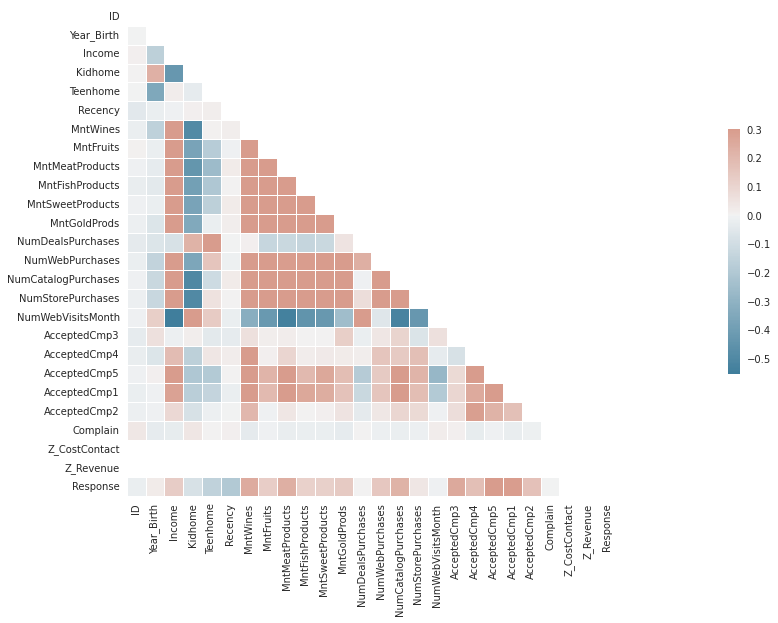

In [ ]:
# Correlation

mask = np.triu(np.ones_like(df.corr(), dtype=bool))
f, ax = plt.subplots(figsize=(40, 9))
cmap = sb.diverging_palette(230, 20, as_cmap=True)
sb.heatmap(df.corr(), mask=mask, cmap=cmap, vmax=.3, center=0,
           square=True, linewidths=.5, cbar_kws={"shrink": .5})

## ___Filtreur___

In [ ]:
# parcour du dataframe filtrer et suppression des données
df_copy1 = df

# Ordonner les valeurs de la date
df_copy1['Dt_Customer'] = pd.to_datetime(df_copy1['Dt_Customer'], format="%d/%m/%Y")

# filtrer les valeurs NAN

df_copy1['Income'].fillna(value = df_copy1['Income'].mean(), inplace=True);
#df_copy1.isnull().sum()

# filtrer les doublons
df_copy1 = df_copy1.drop_duplicates(subset=['Year_Birth', 'Education','Marital_Status', 'Income'])

# filtrer et unifier la colonne 'marital_status'
df_copy1 =df_copy1.replace({'Marital_Status': ['Widow', 'Alone', 'Divorced']}, {'Marital_Status': 'Single'}, regex=False)
df_copy1 = df_copy1.replace({'Marital_Status': 'Married'}, {'Marital_Status': 'Together'}, regex=False)

# filtrer la columns Income --------> "int" pour suppression des ",|| ."
df_copy1['Income'] = df_copy1["Income"].round(0).astype(int)

### ___Suppression___

In [ ]:
# suppression des lignes "absurdes" (qui possèdent des valeurs ne semblants pas cohérentes / réponses au hasard des utilisateurs)
#---------------------------------------------------------------------------------------------------------------------------------#
# "marital_status" étranges / non classables

df_copy1.drop(df_copy1.index[df_copy1['Marital_Status'] == 'Absurd'], inplace=True)
df_copy1.drop(df_copy1.index[df_copy1['Marital_Status'] == 'YOLO'], inplace=True)

# "Income" étranges
df_copy1.drop(df_copy1.index[df_copy1['Income'] == 666666], inplace=True)

# "Year_Birth" étranges
df_copy1.drop(df_copy1.index[df_copy1['Year_Birth'] <= 1939], inplace=True)

### ___Pertinence___

In [ ]:
# Copie du DF en ne gardant uniquement que les colonnes qui nous semblents pertinentes 
# au regroupement par le comportement d'achat 

df_focused_infos = df_copy1[["Year_Birth", "Education", "Marital_Status", "Income", "Kidhome", "Teenhome", 
        "Dt_Customer", "Recency", "MntWines","MntFruits", "MntMeatProducts", "MntFishProducts", "MntSweetProducts","MntGoldProds", "NumWebPurchases", "NumCatalogPurchases", 
        "NumStorePurchases", "NumWebVisitsMonth","NumDealsPurchases"]]

#Creation de l'age et determination du nombre d'enfant (pertinence)
colum_sum = ['Kidhome','Teenhome']
df_focused_infos["Age"] = 2021 - df_focused_infos['Year_Birth']
df_focused_infos['Children']=df_focused_infos[colum_sum].sum(axis=1)
df_focused_infos = df_focused_infos.drop(["Year_Birth","Kidhome","Teenhome"], axis=1)


<ipython-input-8-72e6469a5293>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_focused_infos["Age"] = 2021 - df_focused_infos['Year_Birth']
<ipython-input-8-72e6469a5293>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_focused_infos['Children']=df_focused_infos[colum_sum].sum(axis=1)


# __DATA VISUALISATION__

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


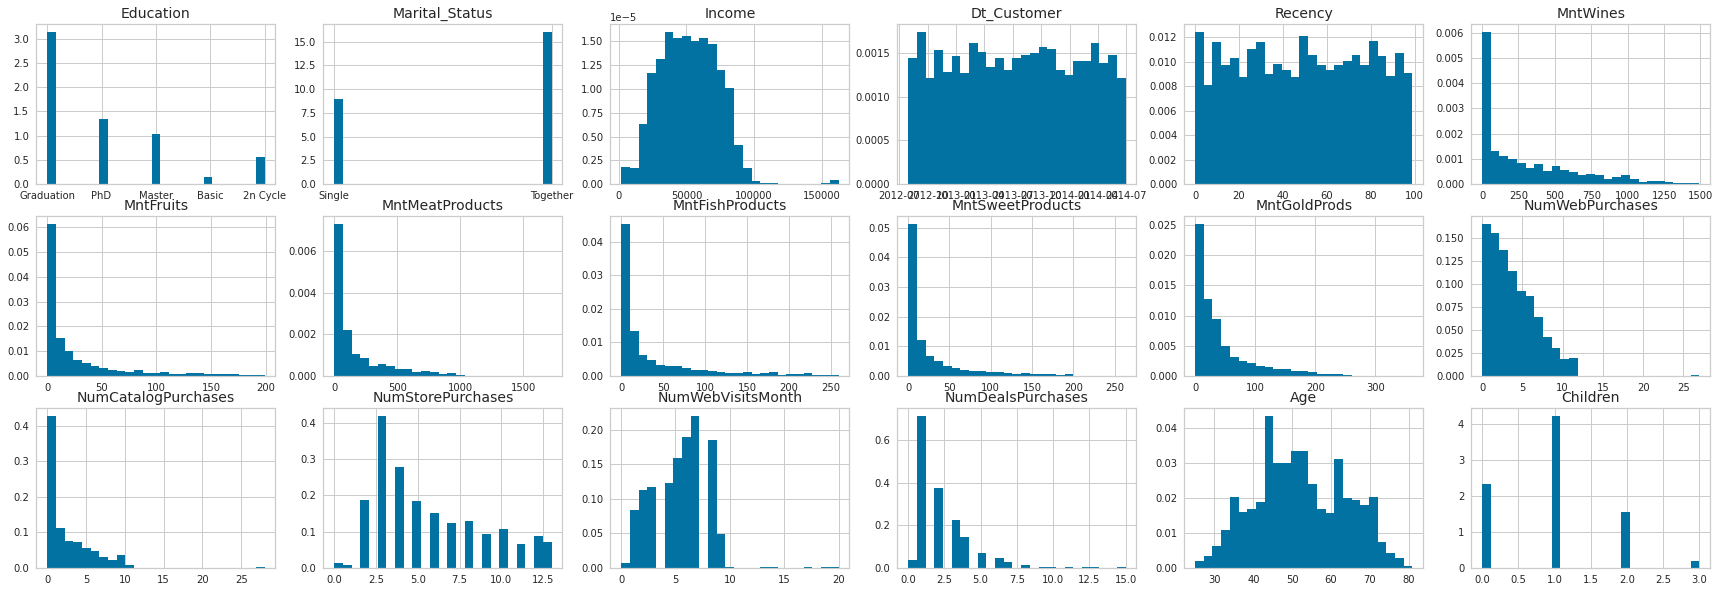

In [ ]:
X = df_focused_infos[df_focused_infos.columns[:]].values

fig = plt.figure(figsize=(30, 10))

for i in range(X.shape[1]):
    ax = fig.add_subplot(3,6, (i+1))
    h = ax.hist(X[:, i], bins=25, density=True, edgecolor='none')
    ax.set_title(df_focused_infos.columns[i], fontsize=14)

### ___Correlation___

<AxesSubplot:>

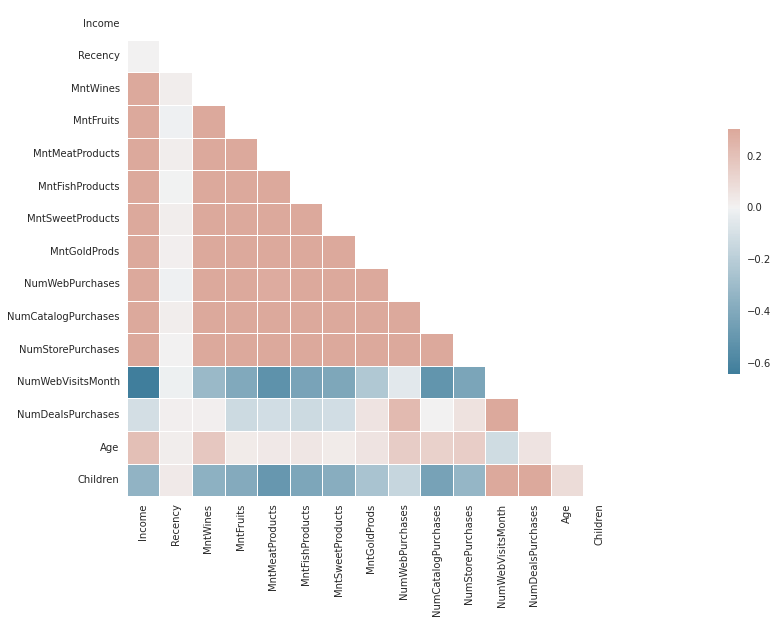

In [ ]:
mask = np.triu(np.ones_like(df_focused_infos.corr(), dtype=bool))
f, ax = plt.subplots(figsize=(40, 9))
cmap = sb.diverging_palette(230, 20, as_cmap=True)
sb.heatmap(df_focused_infos.corr(), mask=mask, cmap=cmap, vmax=.3, center=0,
           square=True, linewidths=.5, cbar_kws={"shrink": .5})

### ___Encoding___

In [ ]:
# marital_status
df_focused_infos['Marital_Status'] = df_focused_infos['Marital_Status'].replace({'Single':0, 'Together':1})

# education
# (need finer tweeking, there is a hierarchy between these values.)

le = LabelEncoder()
df_focused_infos['Education'] = le.fit_transform(df_focused_infos['Education'])
df_focused_infos


,Education,Marital_Status,Income,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,NumDealsPurchases,Age,Children
0,2,0,58138,2012-09-04,58,635,88,546,172,88,88,8,10,4,7,3,64,0
1,2,0,46344,2014-03-08,38,11,1,6,2,1,6,1,1,2,5,2,67,2
2,2,1,71613,2013-08-21,26,426,49,127,111,21,42,8,2,10,4,1,56,0
3,2,1,26646,2014-02-10,26,11,4,20,10,3,5,2,0,4,6,2,37,1
4,4,1,58293,2014-01-19,94,173,43,118,46,27,15,5,3,6,5,5,40,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2232,2,0,26816,2012-08-17,50,5,1,6,3,4,3,0,0,3,4,1,35,0
2235,2,1,61223,2013-06-13,46,709,43,182,42,118,247,9,3,4,5,2,54,1
2237,2,0,56981,2014-01-25,91,908,48,217,32,12,24,2,3,13,6,1,40,0
2238,3,1,69245,2014-01-24,8,428,30,214,80,30,61,6,5,10,3,2,65,1


# __SEGMENTATION__

### 
A partir d'ici on chercher a répondre à la question sur l'analyse de personnalités cliente
nous nous efforcerons d'y répondre en determinant deja 3 grands segments sur lesquels seront reparti notre analyse personnel des données

    segment 1 : client-produit achete
    segment 2 : client - lieu d'achat selon les revenus
    segment 3 : produit acheté - lieu d'achat

# ___K-MEAN___

In [ ]:
#Help define a right k-cluster with -------> Elbown

df_kmean = df_focused_infos[["Age", "Income", "Children", "Recency", "MntWines", "Marital_Status", "Education" ,"MntFruits", "MntMeatProducts", "MntFishProducts", "MntSweetProducts","MntGoldProds", "NumWebPurchases", "NumCatalogPurchases", 
        "NumStorePurchases", "NumWebVisitsMonth","NumDealsPurchases"]]
#---------------------------------------------------------------------------------------------------------------

### ___Standardisation___

In [ ]:
scaler = StandardScaler()
scaler.fit_transform(df_kmean)

df_standard = pd.DataFrame(scaler.transform(df_kmean),columns= df_kmean.columns )

### ___PCA___

In [ ]:
#Apply the PCA on The Elbown Method
pca = PCA(n_components=7)
pca.fit(df_standard)

variance = pca.explained_variance_ratio_.sum()*100
variance
#😎😎😎

75.624640622631

In [ ]:
#variance expliquée
print(pca.explained_variance_)

[6.06899084 1.77416712 1.34978048 1.00962285 1.00806657 0.89147746
 0.76041356]


In [ ]:
#nombre de composant sur lequ
print(pca.explained_variance_ratio_)

[0.35682377 0.10431141 0.07935978 0.05936035 0.05926885 0.05241404
 0.0447082 ]


### ___Elbown___

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


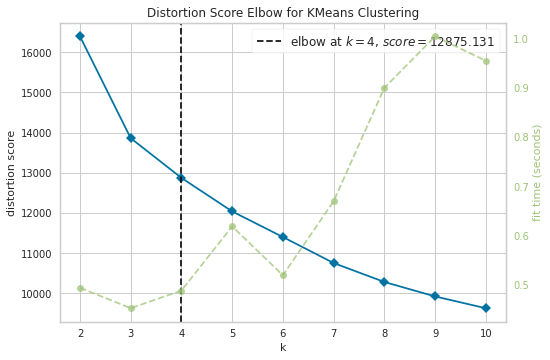

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
Data_pca = pd.DataFrame(pca.transform(df_standard))

elb_vis = KElbowVisualizer(KMeans(), k=10)
elb_vis.fit(Data_pca) 
elb_vis.show()

### ___Silhouette___

SilhouetteVisualizer(ax=<AxesSubplot:>, colors='yellowbrick',
                     estimator=KMeans(n_clusters=4, random_state=0))

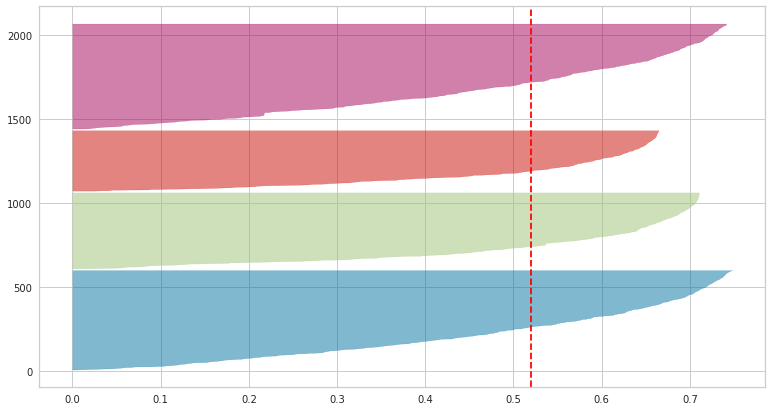

In [ ]:
#silhouette (evaluation de la qualite d'un cluster) ------->  [3,4,5]
plt.figure(figsize=(13,7))
k_model = KMeans(n_clusters= 4, random_state= 0)
    #fit the visualisation
visualizer = SilhouetteVisualizer(k_model, colors='yellowbrick')
visualizer.fit(df_kmean)

# __CLUSTERING__

### ___Label___

In [ ]:
# Generate a label int values of my clusters 
 
kmeans = KMeans(n_clusters = 4, random_state=50)
 
label_prediction = kmeans.fit_predict(Data_pca)
label_prediction

array([0, 1, 0, ..., 0, 3, 2], dtype=int32)

In [ ]:
df["Clusters"] = pd.Series(label_prediction)
labels = ["Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4"]

cluster1_num = df_focused_infos[df["Clusters"]==0].shape[0]
cluster2_num = df_focused_infos[df["Clusters"]==1].shape[0]
cluster3_num = df_focused_infos[df["Clusters"]==2].shape[0]
cluster4_num = df_focused_infos[df["Clusters"]==3].shape[0]
values = [cluster1_num, cluster2_num, cluster3_num, cluster4_num]

fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=0.6, title="CLUSTERS")])
fig.show()

<ipython-input-22-44267c191246>:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

<ipython-input-22-44267c191246>:5: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

<ipython-input-22-44267c191246>:6: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

<ipython-input-22-44267c191246>:7: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [ ]:
Data_pca = pd.DataFrame(pca.transform(df_standard), columns=["col1", "col2", "col3","col4", "col5", "col6", "col7"])
fig = px.scatter_3d(Data_pca, x="col1", y="col2", z="col3", color=label_prediction, title=f"Total Explained Variance: {variance:.2f}%")
fig.show()

# ___INTERPRETATION___

### Segment 1

### Segment 2

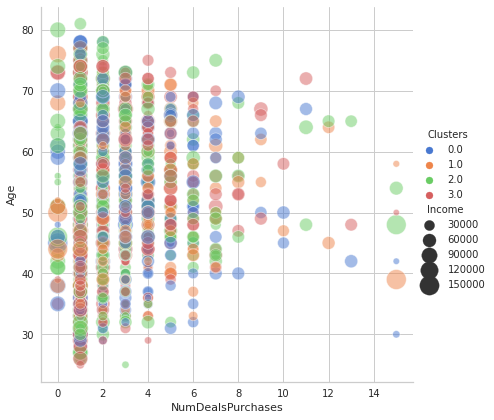

In [ ]:
sb.relplot(x=df_kmean["NumDealsPurchases"], y=df_kmean["Age"], hue=df["Clusters"], size="Income",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=df_kmean)

### Segment 3

/shared-libs/python3.9/py/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning:

73.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/shared-libs/python3.9/py/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning:

76.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/shared-libs/python3.9/py/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning:

25.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



[Text(0, 0.5, '')]

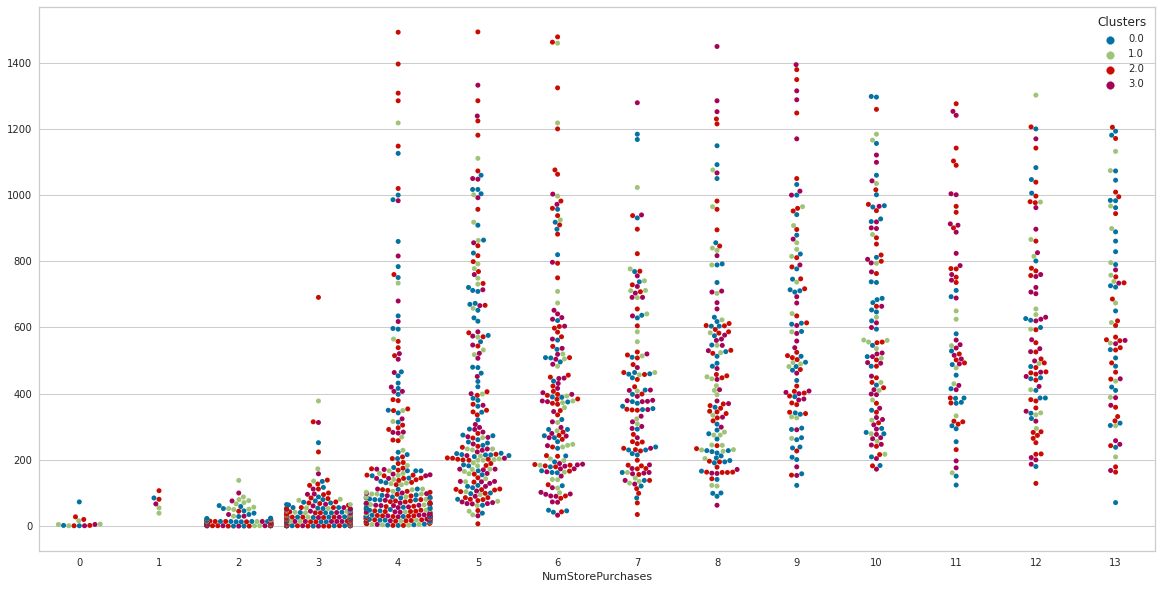

In [ ]:
plt.figure(figsize=(20,10))
ax = sb.swarmplot(data=df_kmean, x=df_kmean["NumStorePurchases"], y=df_kmean["MntWines"], hue=df["Clusters"])
ax.set(ylabel="")


# ___Conclusion___

##### Selon différents segments nous pouvons deduire que la reponse a l'étude du comportement client depend fortement de ce que nous voulon améliorer dans son expérience. Est-ce :
###### -une meilleur proposition de produit chez les plus jeunes;
###### -optimiser la vente des produits sur certains lieux; etc...


##### il serait plus pertinent de voir des professionnels du metier pour deduire qu'elle étude du comportement serait la plus pertinente pour les objectifs de l'entreprise/start_up

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0c8365e5-af89-4479-b1c9-90e8728d426b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>